In [1]:
import numpy as np 
import pandas as pd
import os

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


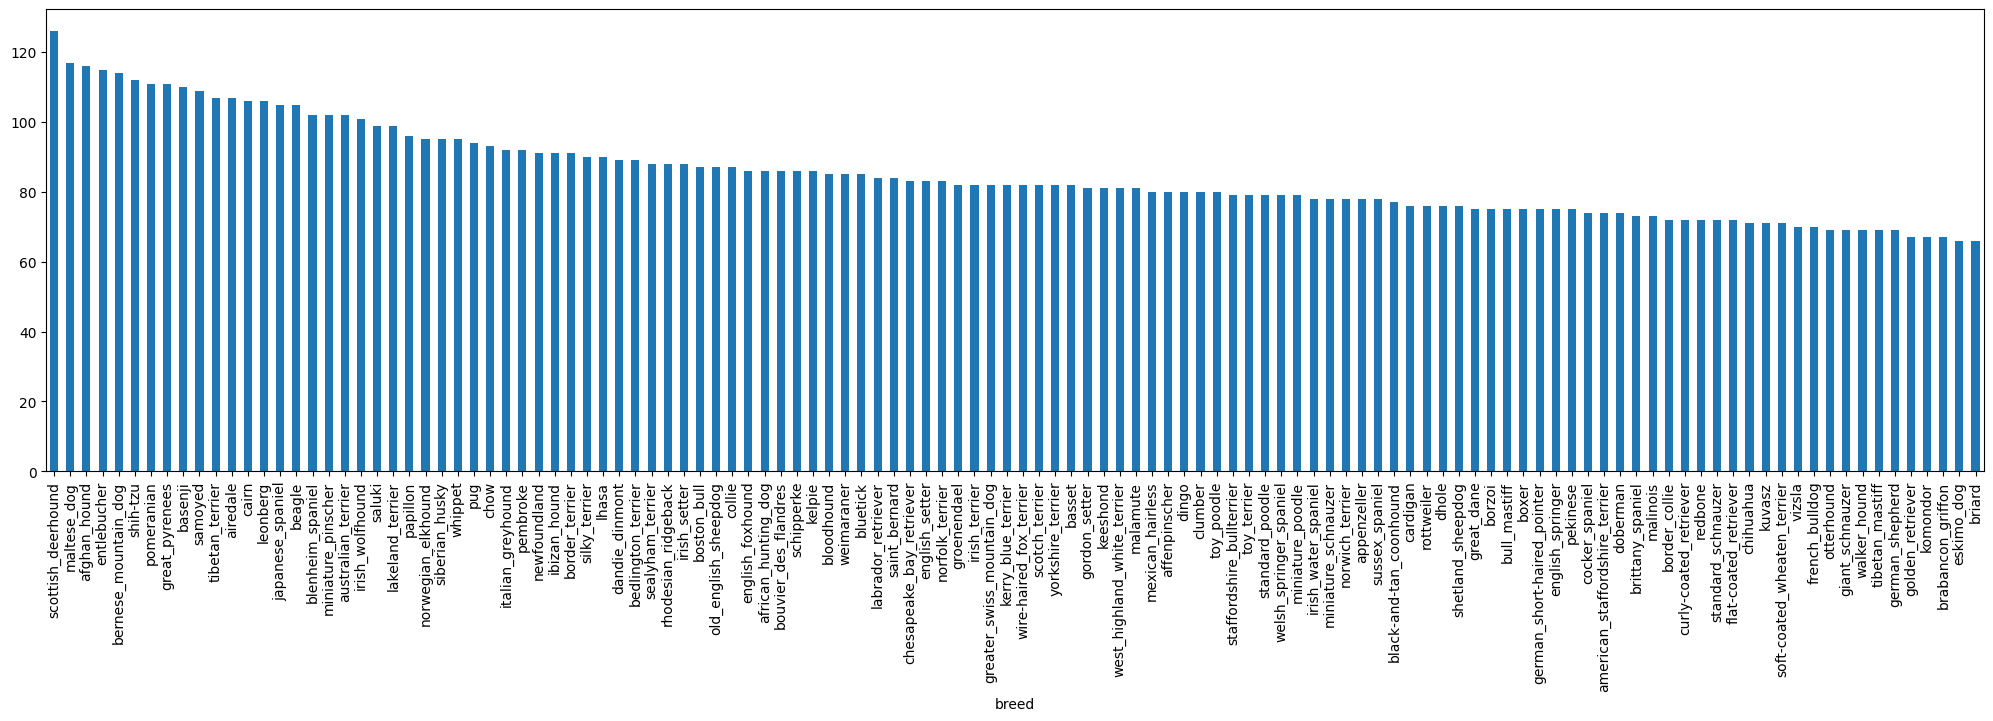

In [2]:
train_data_path = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
display(train_data_path.head())
train_data_path['breed'].value_counts().plot(figsize=(25,6),kind='bar');

In [3]:
from fastai.vision.all import *

def label_func(fname):
    # Extract label from filename or path, e.g. the parent folder name
    img_id = fname.stem
    return train_data_path.loc[train_data_path['id'] == img_id, 'breed'].values[0]
    
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=label_func,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75,
                                           do_flip=True, max_rotate=30)) #,
                                           #max_lighting=0.2, max_warp=0.2,
                                           #p_affine=0.75, p_lighting=0.75))
dls = pets.dataloaders('/kaggle/input/dog-breed-identification/train/')

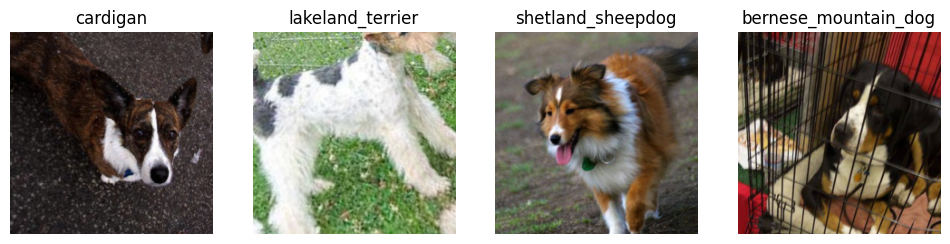

In [4]:
dls.show_batch(max_n=4, nrows=1)

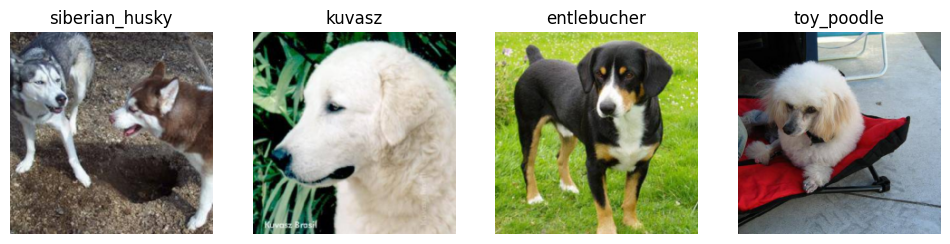

In [5]:
dls.valid.show_batch(max_n=4, nrows=1)

In [6]:
"""
# Find the best image model - https://www.kaggle.com/code/jhoward/which-image-models-are-best
! git clone --depth 1 https://github.com/rwightman/pytorch-image-models.git
%cd pytorch-image-models/results 

df_results = pd.read_csv('results-imagenet.csv')
df_results['model_org'] = df_results['model'] 
df_results['model'] = df_results['model'].str.split('.').str[0]
display(df_results.head())

def get_data(part, col):
    df = pd.read_csv(f'benchmark-{part}-amp-nhwc-pt113-cu117-rtx3090.csv').merge(df_results, on='model')
    df['secs'] = 1. / df[col]
    df['family'] = df.model.str.extract('^([a-z]+?(?:v2)?)(?:\d|_|$)')
    df = df[~df.model.str.endswith('gn')]
    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'
    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'
    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg|swin')]

df = get_data('infer', 'infer_samples_per_sec')
"""

"\n# Find the best image model - https://www.kaggle.com/code/jhoward/which-image-models-are-best\n! git clone --depth 1 https://github.com/rwightman/pytorch-image-models.git\n%cd pytorch-image-models/results \n\ndf_results = pd.read_csv('results-imagenet.csv')\ndf_results['model_org'] = df_results['model'] \ndf_results['model'] = df_results['model'].str.split('.').str[0]\ndisplay(df_results.head())\n\ndef get_data(part, col):\n    df = pd.read_csv(f'benchmark-{part}-amp-nhwc-pt113-cu117-rtx3090.csv').merge(df_results, on='model')\n    df['secs'] = 1. / df[col]\n    df['family'] = df.model.str.extract('^([a-z]+?(?:v2)?)(?:\\d|_|$)')\n    df = df[~df.model.str.endswith('gn')]\n    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'\n    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'\n    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg

In [7]:
"""
import plotly.express as px
w,h = 1000,1000

def show_all(df, title, size):
    return px.scatter(df, width=w, height=h, size=df[size]**2, title=title,
        x='secs',  y='top1', log_x=True, color='family', hover_name='model_org', hover_data=[size])

show_all(df, 'Inference', 'infer_img_size')
"""

"\nimport plotly.express as px\nw,h = 1000,1000\n\ndef show_all(df, title, size):\n    return px.scatter(df, width=w, height=h, size=df[size]**2, title=title,\n        x='secs',  y='top1', log_x=True, color='family', hover_name='model_org', hover_data=[size])\n\nshow_all(df, 'Inference', 'infer_img_size')\n"

In [8]:
"""
import timm
timm.list_models('convnext*')
"""

"\nimport timm\ntimm.list_models('convnext*')\n"

In [9]:
# beitv2_large_patch16_224, convnextv2_base - does not work
# convnext_tiny - 0.33, beitv2_base_patch16_224 - 0.31 works
from fastai.optimizer import ranger
learn = vision_learner(dls, "beitv2_base_patch16_224", metrics=accuracy,
                       loss_func=CrossEntropyLossFlat(), opt_func=ranger).to_fp16()
#learn.add_cb(MixUp())

#lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
#print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

In [10]:
learn.fine_tune(5, base_lr=1e-3, freeze_epochs=2) #0.002 vs 0.00613

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,5.675961,3.062959,0.376712,02:00
1,1.627553,0.362850,0.897749,01:59


epoch,train_loss,valid_loss,accuracy,time
0,0.595367,0.317449,0.903620,02:42
1,0.474226,0.266747,0.920254,02:42
2,0.370276,0.268438,0.915851,02:42
3,0.328495,0.261507,0.923679,02:42
4,0.303225,0.259291,0.920254,02:42


In [11]:
learn.save('beitv2_ce')

Path('models/beitv2_ce.pth')

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.confusion_matrix()
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

array([[14,  0,  0, ...,  0,  0,  0],
       [ 0, 18,  0, ...,  0,  0,  0],
       [ 0,  0, 24, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 20,  0,  0],
       [ 0,  0,  0, ...,  0, 10,  0],
       [ 0,  0,  0, ...,  0,  0, 13]])

In [13]:
interp.most_confused (min_val=1)

[('siberian_husky', 'eskimo_dog', 9),
 ('collie', 'border_collie', 7),
 ('toy_poodle', 'miniature_poodle', 7),
 ('cardigan', 'pembroke', 6),
 ('english_foxhound', 'walker_hound', 6),
 ('staffordshire_bullterrier', 'american_staffordshire_terrier', 6),
 ('walker_hound', 'english_foxhound', 6),
 ('appenzeller', 'bernese_mountain_dog', 4),
 ('lhasa', 'shih-tzu', 4),
 ('australian_terrier', 'silky_terrier', 3),
 ('eskimo_dog', 'siberian_husky', 3),
 ('irish_wolfhound', 'scottish_deerhound', 3),
 ('lhasa', 'tibetan_terrier', 3),
 ('american_staffordshire_terrier', 'staffordshire_bullterrier', 2),
 ('appenzeller', 'entlebucher', 2),
 ('appenzeller', 'greater_swiss_mountain_dog', 2),
 ('australian_terrier', 'yorkshire_terrier', 2),
 ('border_collie', 'collie', 2),
 ('collie', 'shetland_sheepdog', 2),
 ('english_springer', 'german_short-haired_pointer', 2),
 ('malamute', 'siberian_husky', 2),
 ('redbone', 'rhodesian_ridgeback', 2),
 ('scottish_deerhound', 'irish_wolfhound', 2),
 ('shih-tzu', '

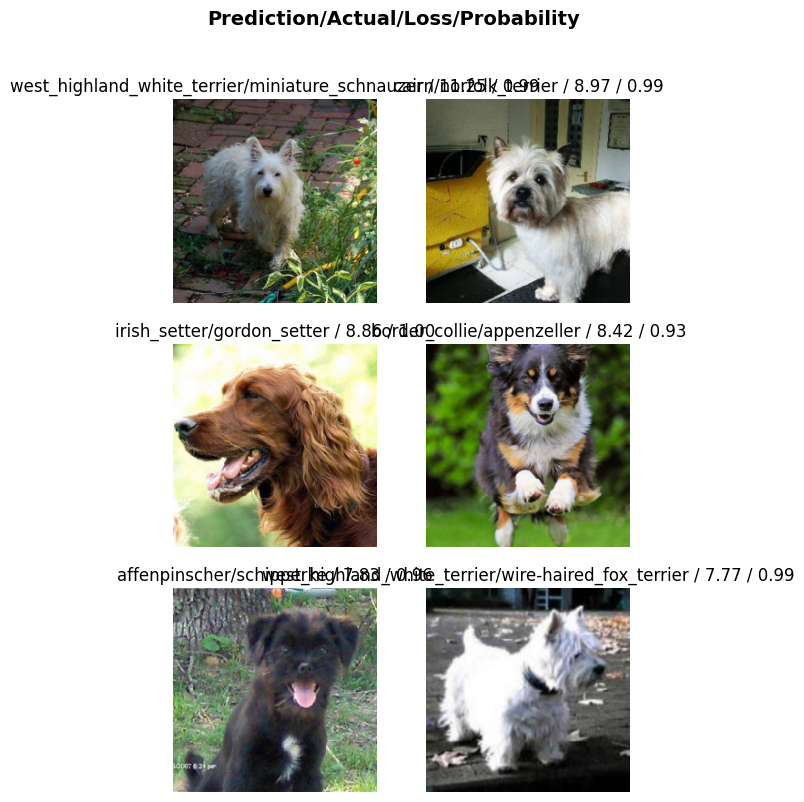

In [14]:
interp.plot_top_losses(6, nrows=3)

In [15]:
test_base_dir= "/kaggle/input/dog-breed-identification/test/"
test_files = list(Path(test_base_dir).glob("*.jpg"))
test_dl = learn.dls.test_dl(test_files)
pred_scores, _ = learn.get_preds(dl=test_dl)

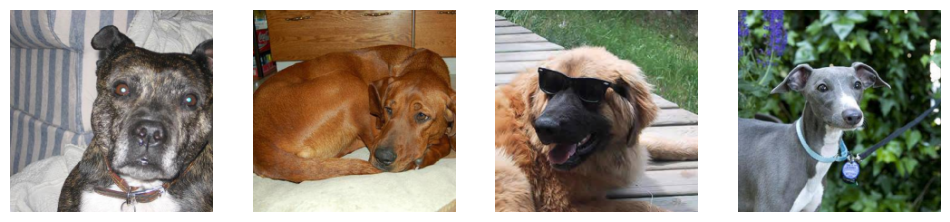

In [16]:
test_dl.show_batch(max_n=4, nrows=1)

In [17]:
#test_data_path = [test_base_dir + fname for fname in os.listdir(test_base_dir)]
unique_breeds = np.unique(train_data_path['breed'])

test_ids = [fname[:-4] for fname in os.listdir(test_base_dir)]
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df["id"] = test_ids
preds_df[list(unique_breeds)] = pred_scores
display(preds_df.head())
preds_df.to_csv("submission.csv",index=False)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,3.501173e-06,3.523803e-07,9.913224e-06,1.733042e-05,6.601126e-02,1.407578e-05,2.813005e-05,3.020862e-05,0.000002,...,1.373424e-06,1.149782e-06,1.568500e-06,7.540457e-07,2.331715e-06,2.639994e-05,3.963101e-05,1.321006e-05,9.293054e-07,1.381495e-06
1,f7a32505c12649183c5991ecfa7d68b3,1.541450e-06,3.155137e-06,9.444317e-08,1.683380e-08,7.141768e-07,4.575902e-08,2.425863e-07,1.512600e-05,0.000008,...,2.478545e-07,6.725880e-07,8.451834e-06,9.282525e-06,9.082511e-08,2.532371e-07,3.508989e-07,4.896326e-06,4.899647e-08,3.775641e-07
2,bc6d50ffb4644feb34530aa58943e85b,3.482904e-06,4.420695e-05,1.260381e-05,3.548661e-05,1.503699e-05,4.321864e-06,1.224141e-05,6.952654e-07,0.000010,...,5.213941e-05,8.980639e-06,1.150395e-05,1.906896e-05,3.031915e-06,6.582640e-07,8.268808e-06,2.744053e-07,1.650035e-06,5.895761e-06
3,7cbc041e79135a572aad87904b5c9c57,5.510361e-06,1.496409e-05,4.118891e-06,9.765891e-06,2.512378e-06,9.594293e-07,1.504754e-07,9.102811e-06,0.000001,...,6.431264e-06,2.672853e-05,8.801233e-06,4.501820e-06,7.794819e-05,5.121196e-06,4.483600e-07,1.852261e-02,8.805532e-06,1.890433e-06
4,f3b603f10d6a344f0395fb46b242ff8e,6.435747e-08,2.805818e-07,6.905580e-07,2.433937e-06,2.782623e-07,3.479651e-06,5.482805e-07,8.484450e-08,0.000002,...,4.380235e-08,8.996440e-08,1.872909e-08,1.529599e-07,1.401584e-07,9.997810e-01,7.855673e-07,4.007543e-07,2.466706e-08,2.811570e-08


In [18]:
#pd.set_option("display.max_rows", None)
#preds_df.loc[1]